In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-21  411.299988  417.200012  411.299988  414.350006  413.468231   
2023-08-22  414.399994  417.950012  412.750000  417.049988  416.162445   
2023-08-23  415.049988  417.899994  414.549988  415.200012  414.316406   
2023-08-24  417.450012  420.000000  412.049988  412.500000  411.622162   
2023-08-25  409.950012  411.250000  407.100006  409.950012  409.077576   

              Volume  
Date                  
2023-08-21  360280.0  
2023-08-22  130305.0  
2023-08-23  188156.0  
2023-08-24  126762.0  
2023-08-25  714966.0  


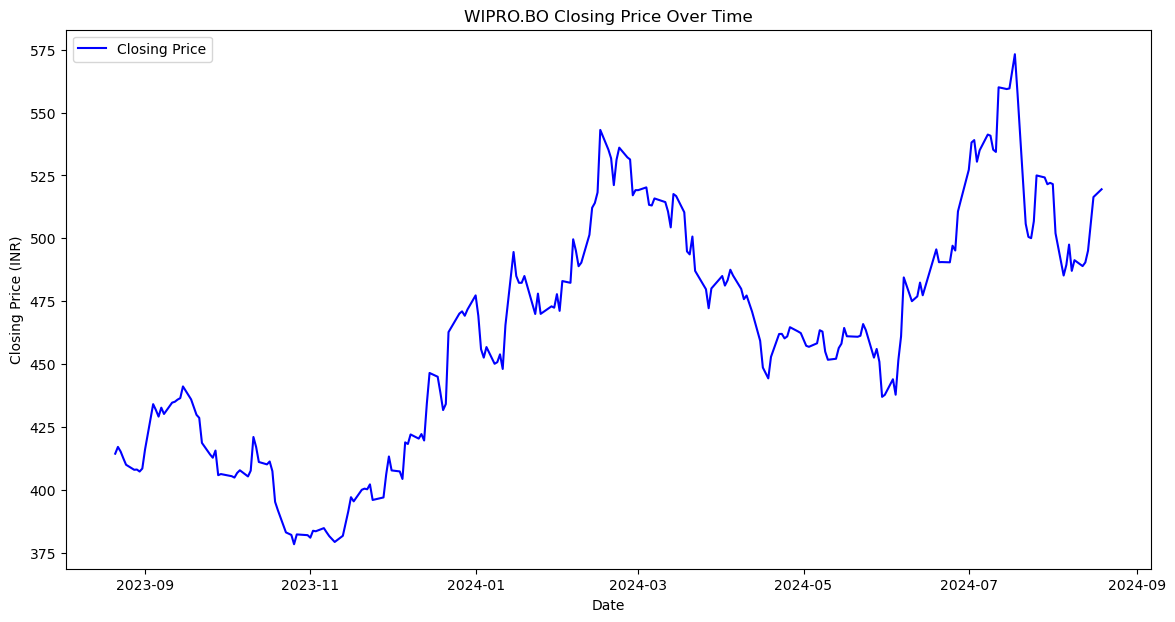

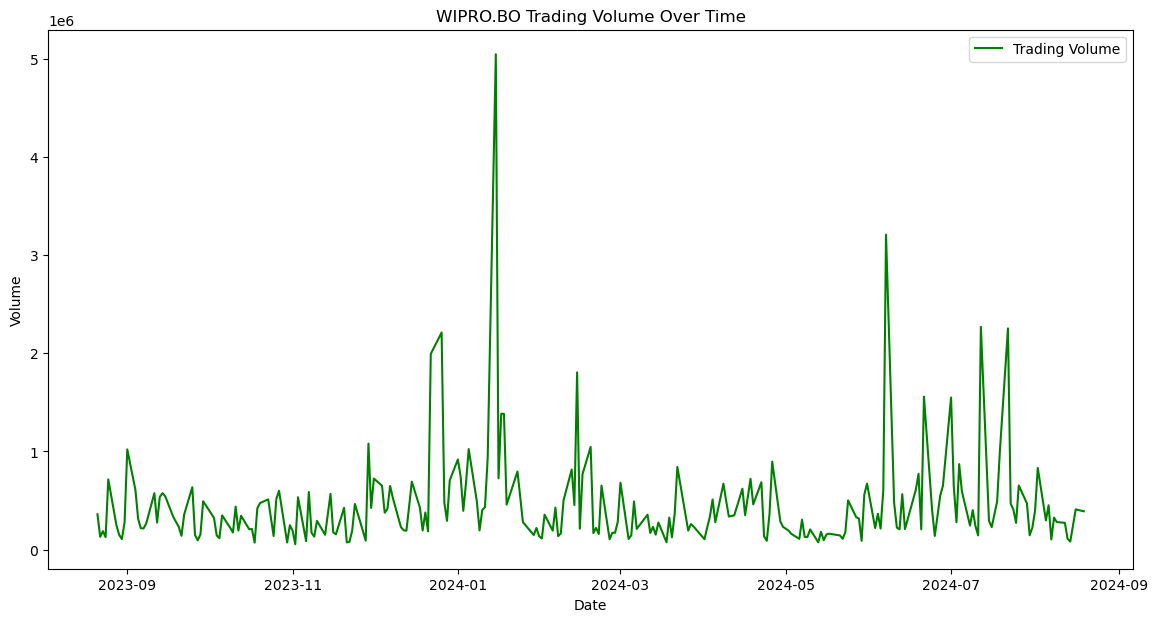

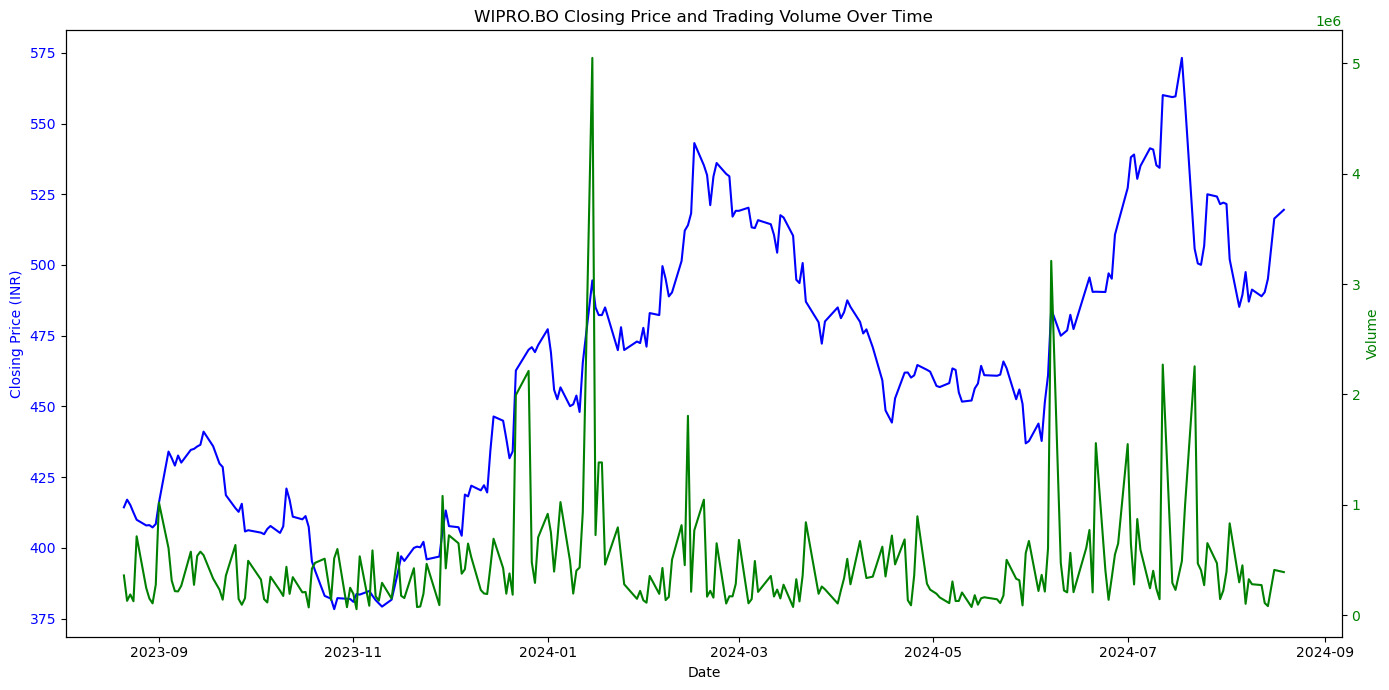

In [3]:

# Load the data
df = pd.read_csv('WIPRO.BO.csv')

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Handle missing values by forward filling
df = df.fillna(method='ffill')

# Display the first few rows
print(df.head())

# Plotting the closing price over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')
plt.title('WIPRO.BO Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (INR)')
plt.legend()
plt.show()

# Plotting the trading volume over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Volume'], label='Trading Volume', color='green')
plt.title('WIPRO.BO Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Plotting both closing price and volume on the same plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot closing price
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price (INR)', color='blue')
ax1.plot(df.index, df['Close'], color='blue', label='Closing Price')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for volume
ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='green')
ax2.plot(df.index, df['Volume'], color='green', label='Volume')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('WIPRO.BO Closing Price and Trading Volume Over Time')
fig.tight_layout()  
plt.show()


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-11-01  382.049988  385.649994  380.149994  380.950012  380.139313   
2023-11-02  383.500000  385.000000  382.200012  383.700012  382.883453   
2023-11-03  385.649994  386.750000  382.500000  383.500000  382.683868   
2023-11-06  385.049988  386.850006  383.500000  384.750000  383.931213   
2023-11-07  385.899994  387.000000  382.700012  383.100006  382.284729   

              Volume      SMA_20      SMA_50  Momentum_10     RSI_14  \
Date                                                                   
2023-11-01  193847.0  398.387501  411.962001   -30.299988  10.069774   
2023-11-02   54935.0  397.330002  411.349001   -23.699982  15.950907   
2023-11-03  533558.0  396.170001  410.678001   -11.700012  18.076465   
2023-11-06   86279.0  395.020001  410.069001    -7.200012  20.828520   
2023-11-07  587317.0  393.910002  409.481001     

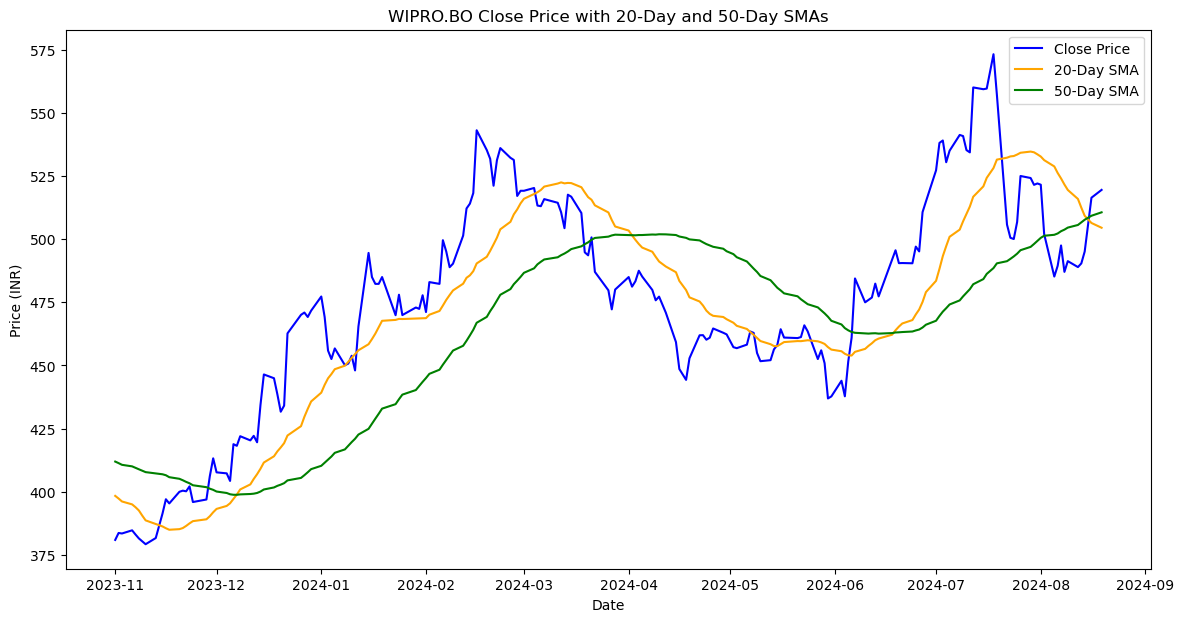

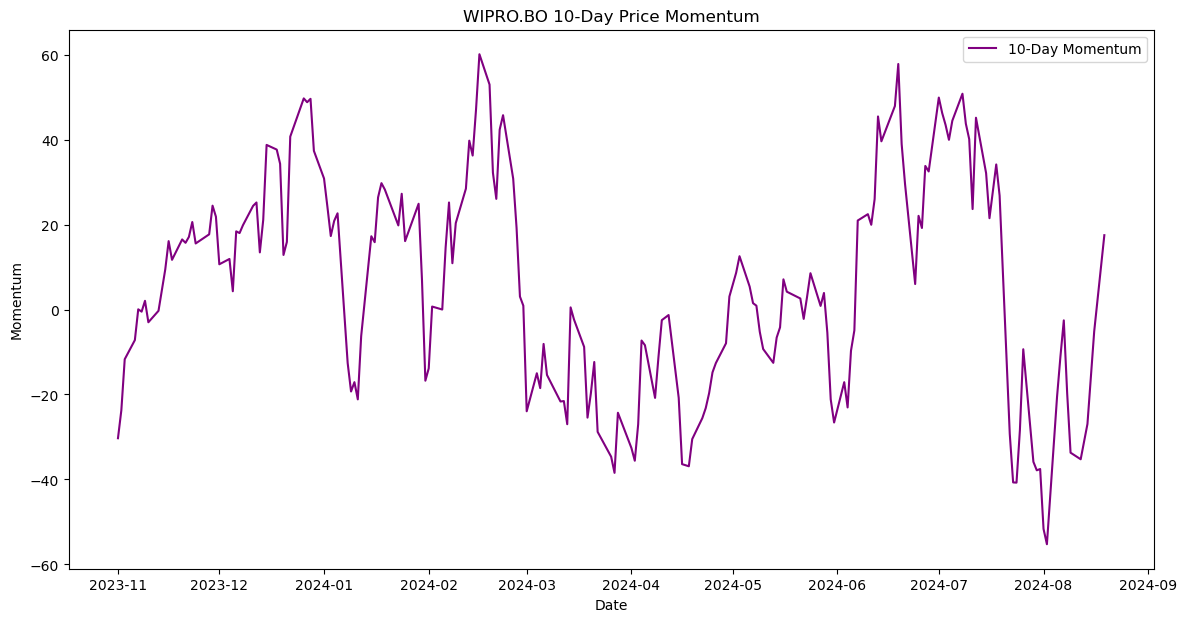

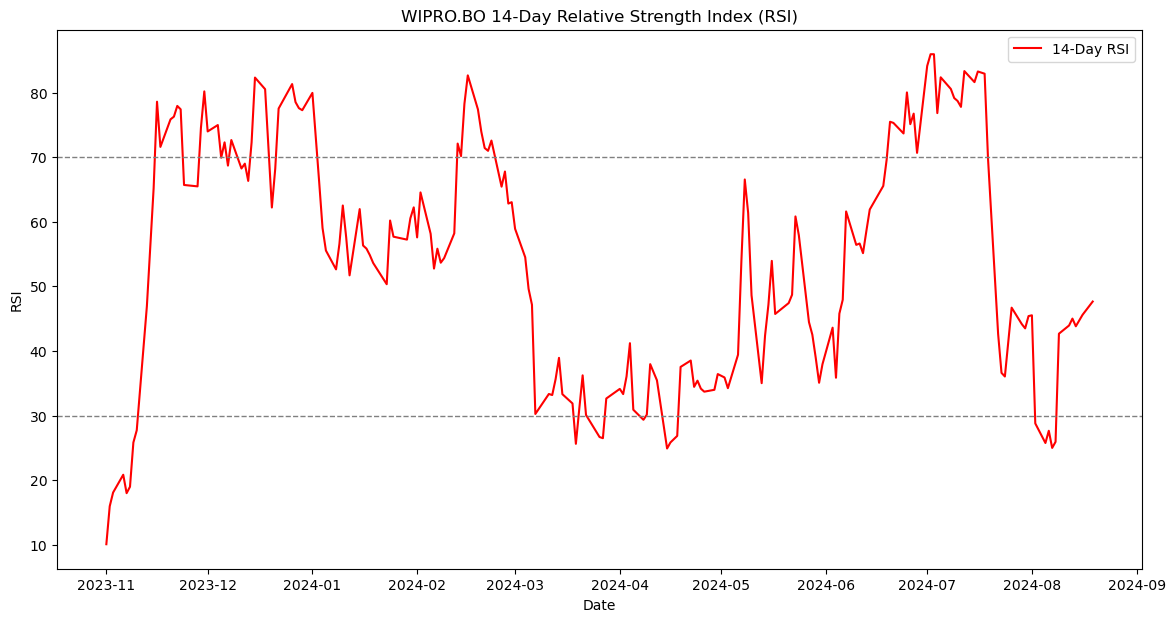

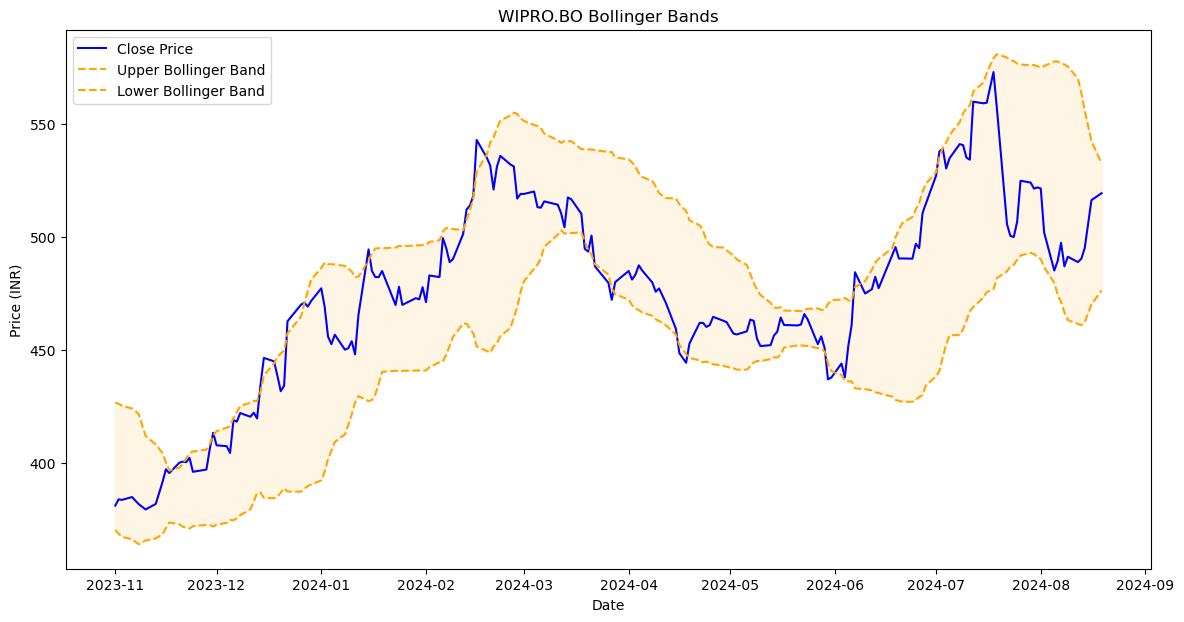

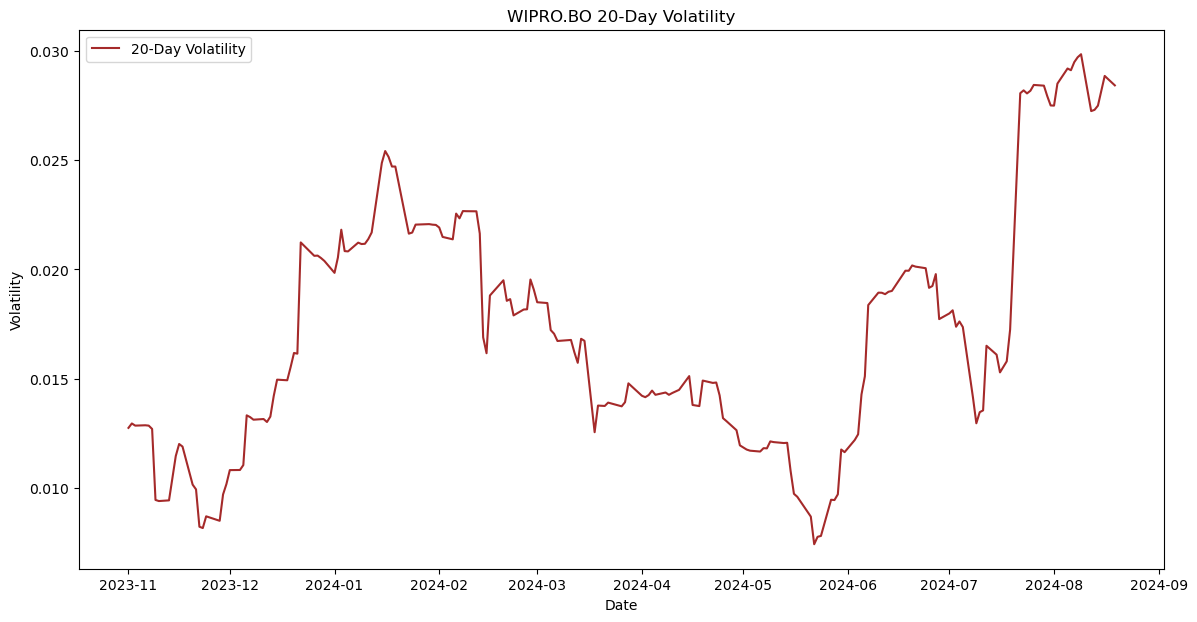

In [4]:
# Simple Moving Averages (SMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Price Momentum
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

# Relative Strength Index (RSI)
def calculate_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI_14'] = calculate_RSI(df)

# Bollinger Bands
df['STDDEV'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['SMA_20'] + (df['STDDEV'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STDDEV'] * 2)

# Volatility (using standard deviation of returns)
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()

# Lag Features
df['Lag_1'] = df['Close'].shift(1)
df['Lag_5'] = df['Close'].shift(5)

# Drop NA values after feature creation
df = df.dropna()

# Display the first few rows of the new features
print(df.head())

# Plotting the Simple Moving Averages (SMA)
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['SMA_20'], label='20-Day SMA', color='orange')
plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='green')
plt.title('WIPRO.BO Close Price with 20-Day and 50-Day SMAs')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

# Plotting Price Momentum
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Momentum_10'], label='10-Day Momentum', color='purple')
plt.title('WIPRO.BO 10-Day Price Momentum')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.show()

# Plotting the Relative Strength Index (RSI)
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['RSI_14'], label='14-Day RSI', color='red')
plt.axhline(70, color='gray', linestyle='--', lw=1)
plt.axhline(30, color='gray', linestyle='--', lw=1)
plt.title('WIPRO.BO 14-Day Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

# Plotting Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(df.index, df['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], color='orange', alpha=0.1)
plt.title('WIPRO.BO Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

# Plotting Volatility
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Volatility_20'], label='20-Day Volatility', color='brown')
plt.title('WIPRO.BO 20-Day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [5]:
# Define features and target
features = df[['SMA_20', 'SMA_50', 'Momentum_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Volatility_20', 'Lag_1', 'Lag_5']]
target = df['Open']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Random Forest MAE: 6.934012042051317
Random Forest RMSE: 11.195617801432274
Random Forest R2: 0.7871747137164795
Next Day Predicted Open Price (Random Forest): 516.5630067800003


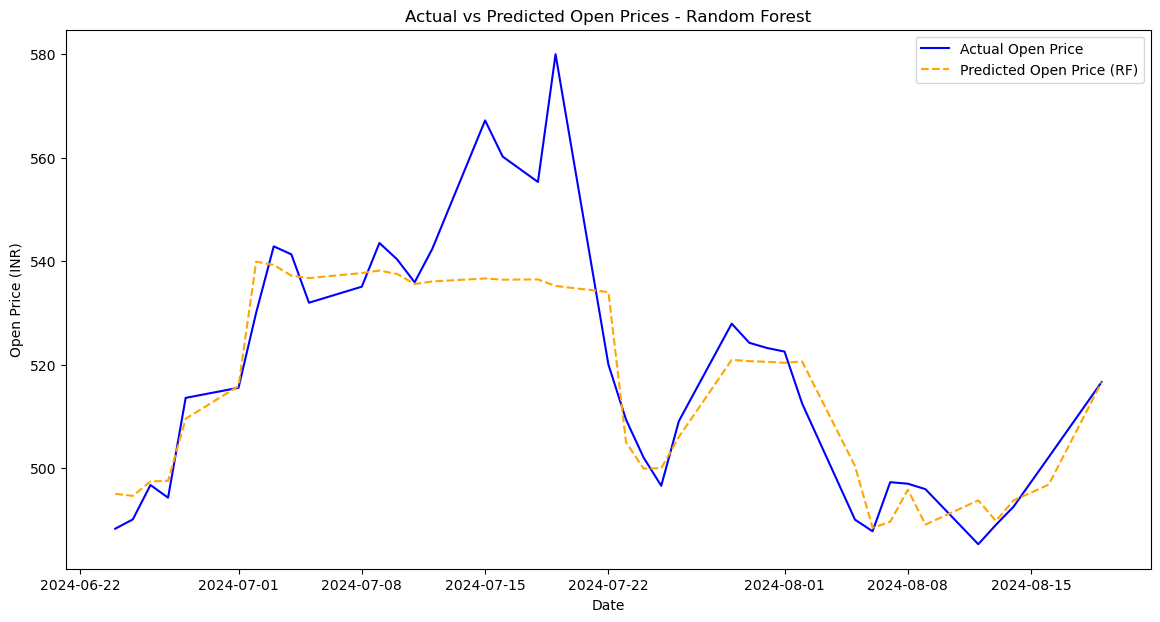

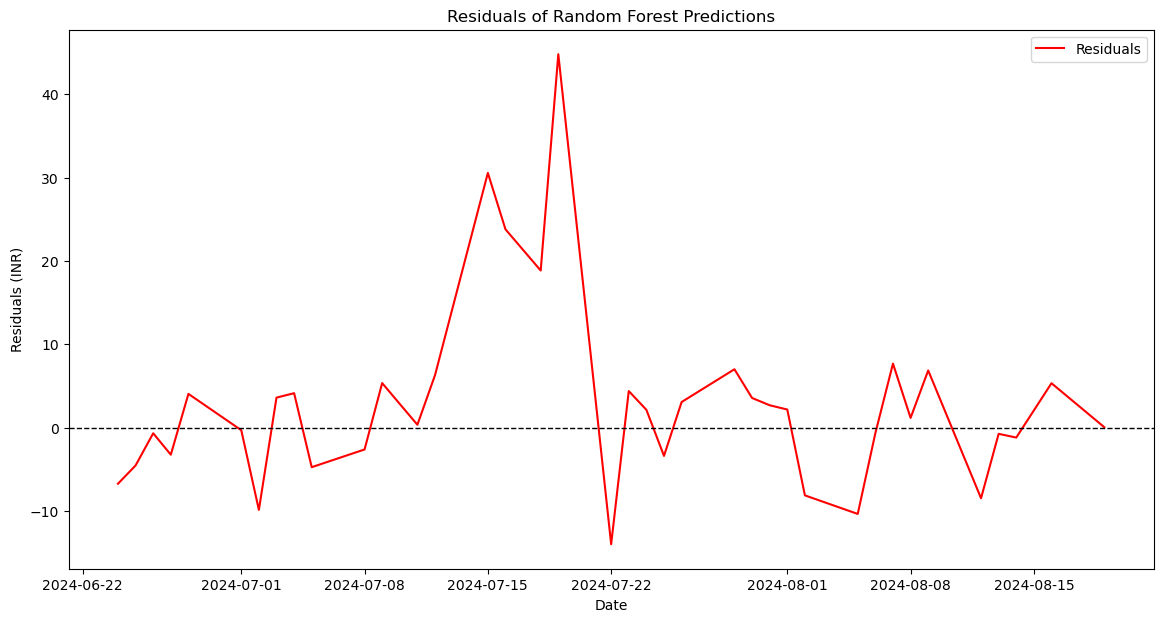

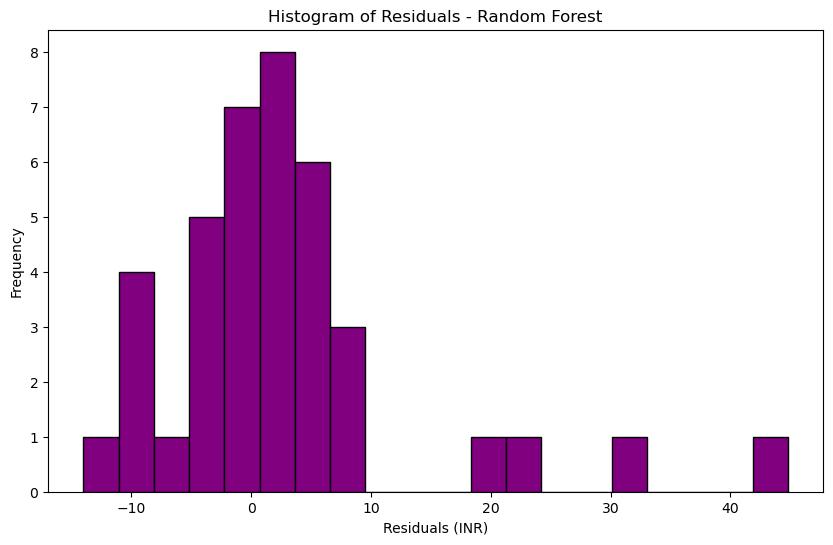

In [6]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluate the model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2: {rf_r2}")

# Predict next day's open price
next_day_rf_prediction = rf_model.predict([X_test_scaled[-1]])
print(f"Next Day Predicted Open Price (Random Forest): {next_day_rf_prediction[0]}")

# Plotting the actual vs predicted open prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Open Price', color='blue')
plt.plot(y_test.index, rf_predictions, label='Predicted Open Price (RF)', color='orange', linestyle='--')
plt.title('Actual vs Predicted Open Prices - Random Forest')
plt.xlabel('Date')
plt.ylabel('Open Price (INR)')
plt.legend()
plt.show()

# Plotting the residuals (difference between actual and predicted values)
residuals = y_test - rf_predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.title('Residuals of Random Forest Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals (INR)')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Residuals - Random Forest')
plt.xlabel('Residuals (INR)')
plt.ylabel('Frequency')
plt.show()


Linear Regression MAE: 4.778334305412201
Linear Regression RMSE: 7.602573342328745
Linear Regression R2: 0.9018594844137513
Next Day Predicted Open Price (Linear Regression): 520.5045730243842


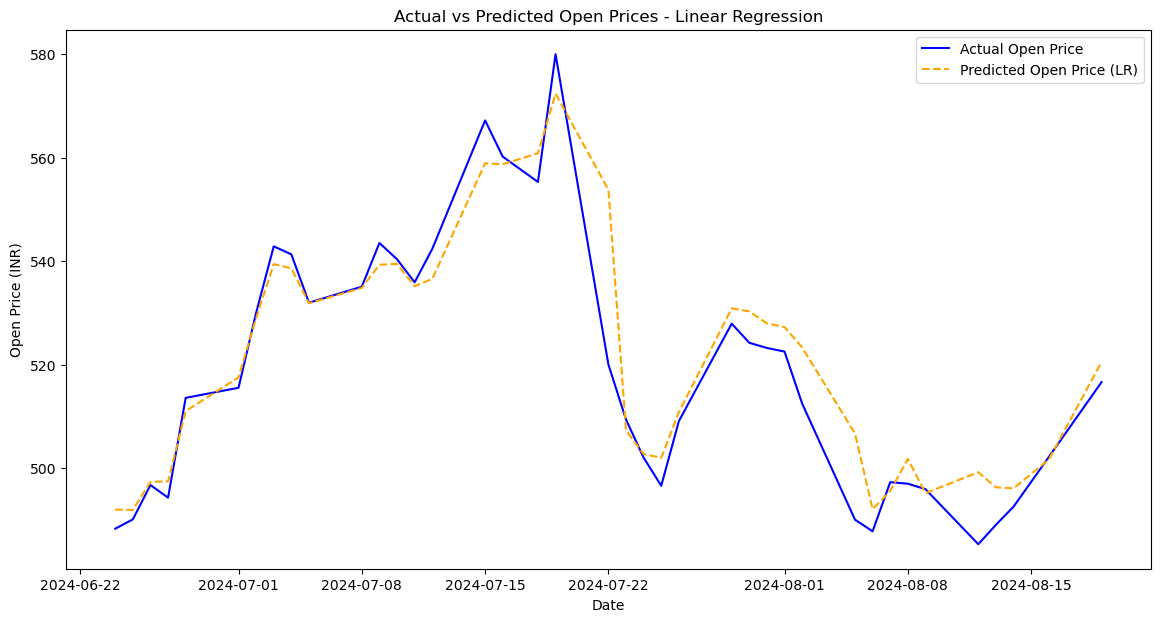

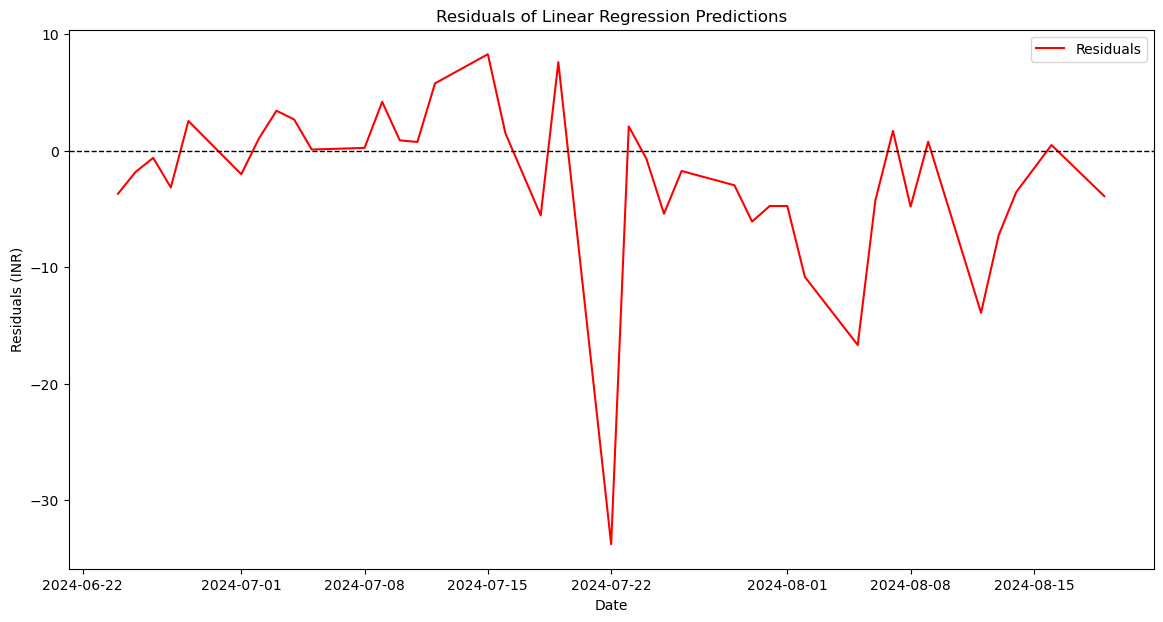

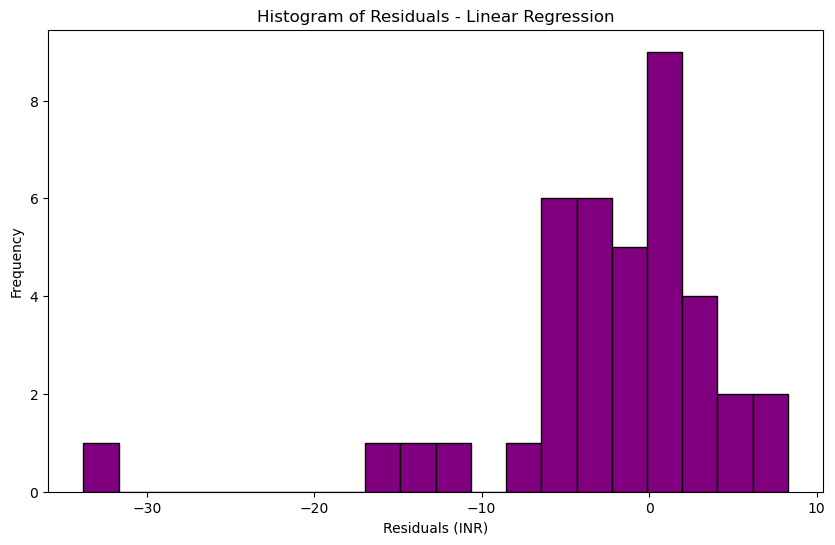

In [7]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_scaled)

# Evaluate the model
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)

print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R2: {lr_r2}")

# Predict next day's open price
next_day_lr_prediction = lr_model.predict([X_test_scaled[-1]])
print(f"Next Day Predicted Open Price (Linear Regression): {next_day_lr_prediction[0]}")

# Plotting the actual vs predicted open prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Open Price', color='blue')
plt.plot(y_test.index, lr_predictions, label='Predicted Open Price (LR)', color='orange', linestyle='--')
plt.title('Actual vs Predicted Open Prices - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Open Price (INR)')
plt.legend()
plt.show()

# Plotting the residuals (difference between actual and predicted values)
residuals = y_test - lr_predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.title('Residuals of Linear Regression Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals (INR)')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Residuals - Linear Regression')
plt.xlabel('Residuals (INR)')
plt.ylabel('Frequency')
plt.show()


Epoch 1/300


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 15.4210 - learning_rate: 0.0010
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 8.7217 - learning_rate: 0.0010
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 4.0899 - learning_rate: 0.0010
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 1.4345 - learning_rate: 0.0010
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.5590 - learning_rate: 0.0010
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.2724 - learning_rate: 0.0010
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.1665 - learning_rate: 0.0010
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.1248 - learning_rate: 0.0010
Epoch 9/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.1101 - learning_rate: 0.0010
Epoch 10/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.1098 - learning_rate: 0.0010
Epoch 11/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.1063 - learning_rate: 0.00

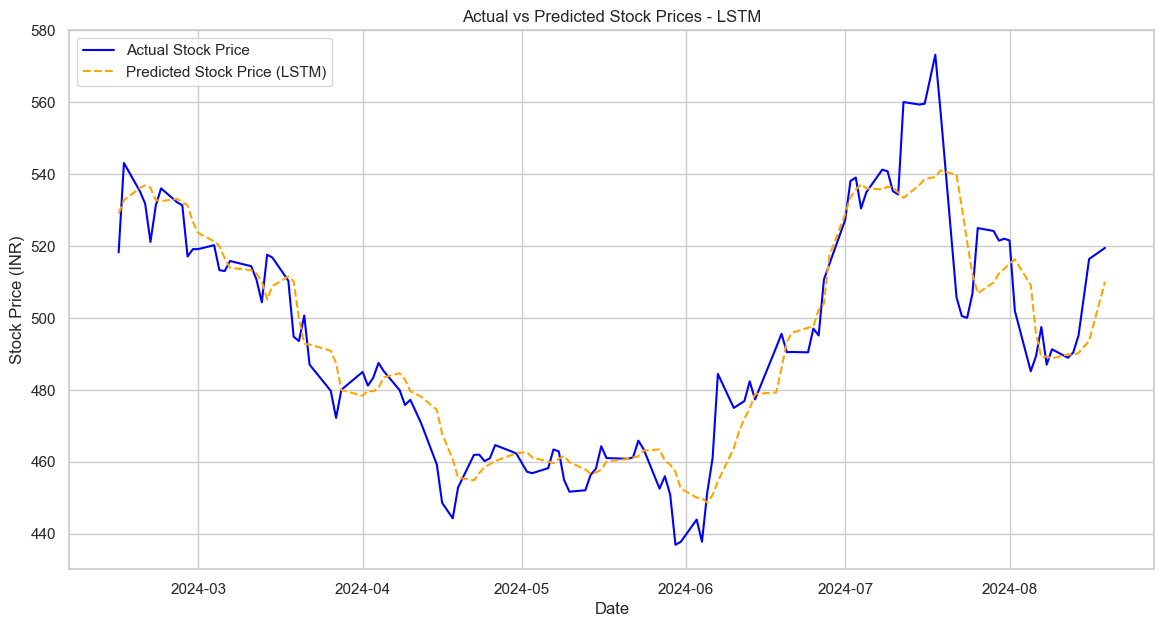

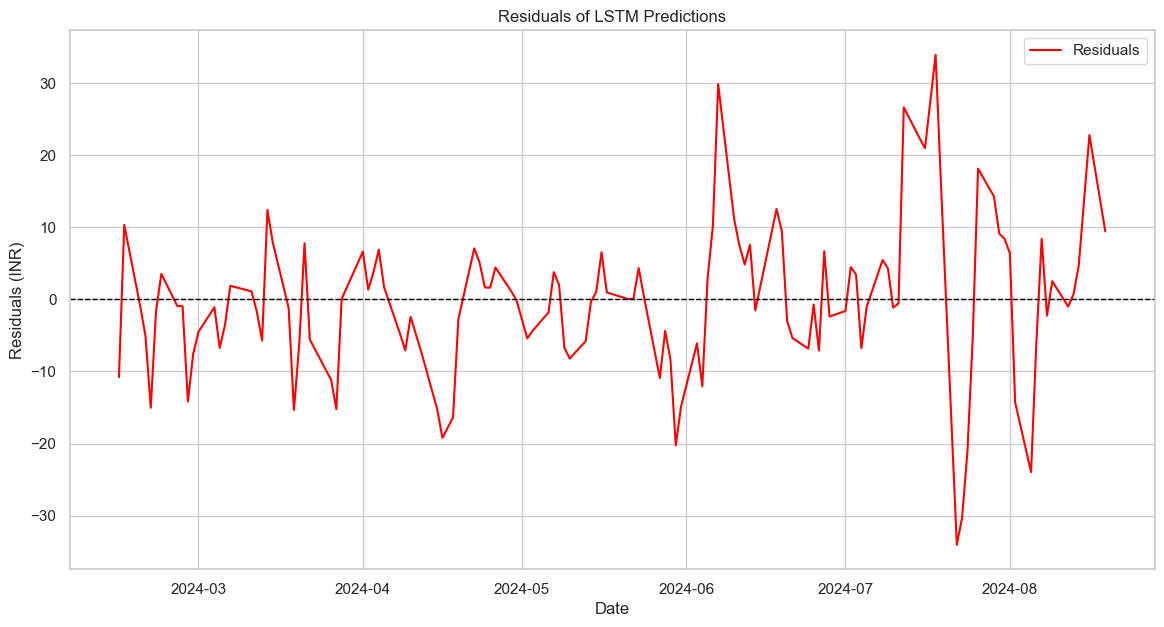

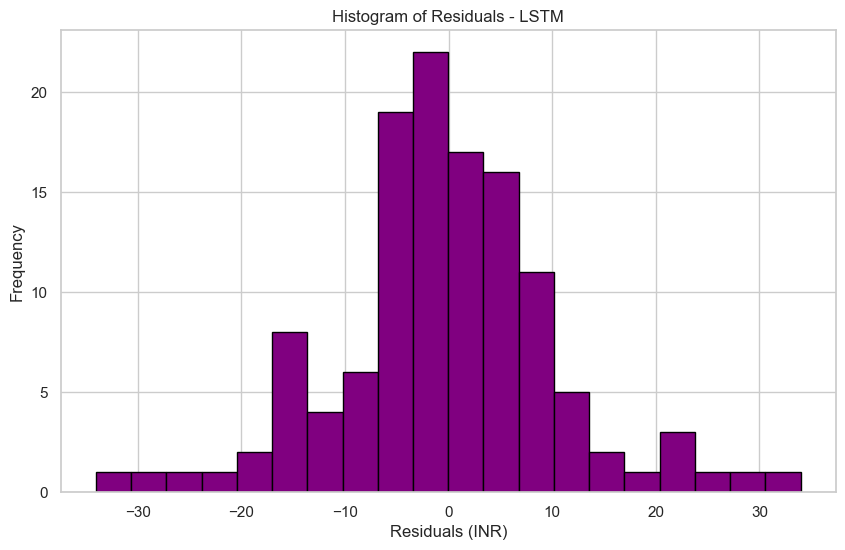

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Next Day Predicted Stock Price (LSTM): 525.719970703125


In [41]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Creating a data structure with 120 time-steps and 1 output (increase time steps)
X_train = []
y_train = []
time_steps = 120  

for i in range(time_steps, len(scaled_data)):
    X_train.append(scaled_data[i-time_steps:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Building the LSTM model
model = Sequential()

# Adding a Bidirectional LSTM layer with L1_L2 regularization
model.add(Bidirectional(LSTM(units=256, return_sequences=True, 
                             input_shape=(X_train.shape[1], 1), 
                             kernel_regularizer=l1_l2(l1=0.001, l2=0.001))))
model.add(Dropout(0.4))  # Adjusted dropout rate

# Adding another LSTM layer with L1_L2 regularization
model.add(LSTM(units=256, return_sequences=True, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.4))

# Adding another LSTM layer
model.add(LSTM(units=256))
model.add(Dropout(0.4))

# Adding the output layer
model.add(Dense(units=1))

# Compile the model using Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Implementing Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.00001)

# Train the model
model.fit(X_train, y_train, epochs=300, batch_size=8, callbacks=[early_stopping, reduce_lr])

# Preparing test data
test_data = scaled_data[len(scaled_data) - len(y_train) - time_steps:]
X_test = []
y_test = data.iloc[len(data) - len(y_train):, 0].values

for i in range(time_steps, len(test_data)):
    X_test.append(test_data[i-time_steps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicting the stock prices
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Evaluating the LSTM model
lstm_mae = mean_absolute_error(y_test, predicted_stock_price)
lstm_rmse = np.sqrt(mean_squared_error(y_test, predicted_stock_price))
lstm_r2 = r2_score(y_test, predicted_stock_price)

print(f"LSTM MAE: {lstm_mae}")
print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM R2: {lstm_r2}")

# Plotting the actual vs predicted stock prices
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Stock Price', color='blue')
plt.plot(data.index[-len(y_test):], predicted_stock_price, label='Predicted Stock Price (LSTM)', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices - LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price (INR)')
plt.legend()
plt.show()

# Calculate residuals
residuals = y_test - predicted_stock_price.flatten()

# Plotting the residuals as a line plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.title('Residuals of LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals (INR)')
plt.legend()
plt.show()

# Plotting the histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Residuals - LSTM')
plt.xlabel('Residuals (INR)')
plt.ylabel('Frequency')
plt.show()

# Predicting the next day's stock price
last_120_days = scaled_data[-time_steps:]
X_input = np.reshape(last_120_days, (1, time_steps, 1))
next_day_prediction = model.predict(X_input)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f"Next Day Predicted Stock Price (LSTM): {next_day_prediction[0][0]}")


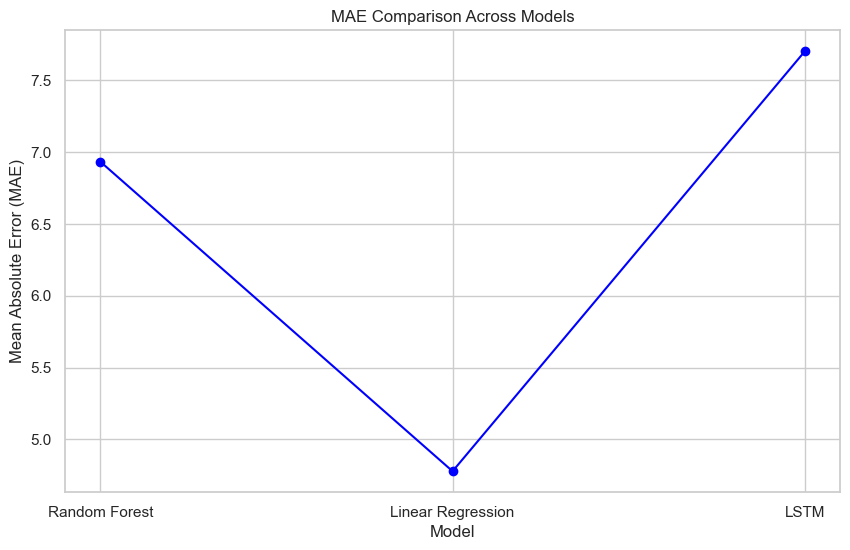

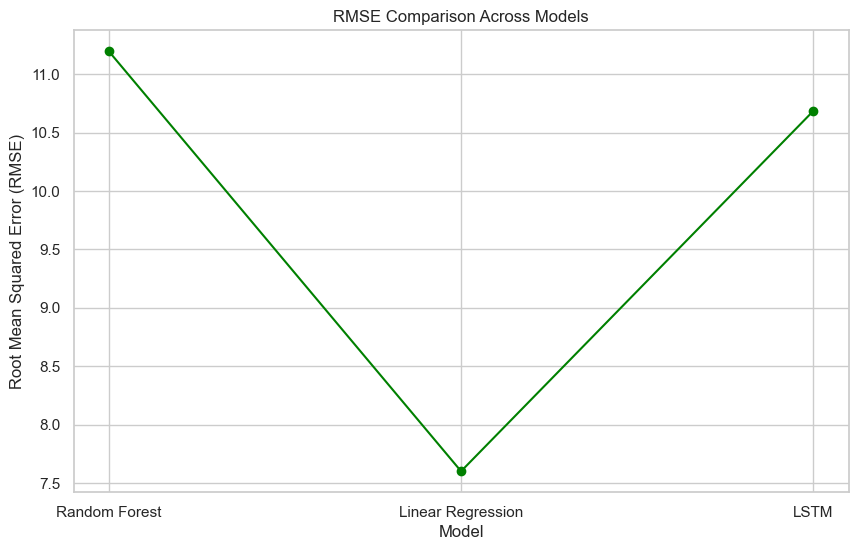

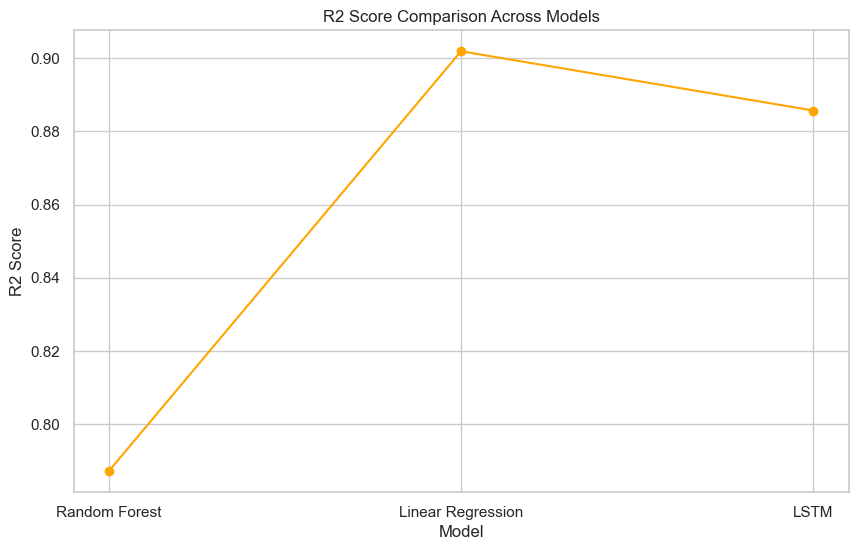

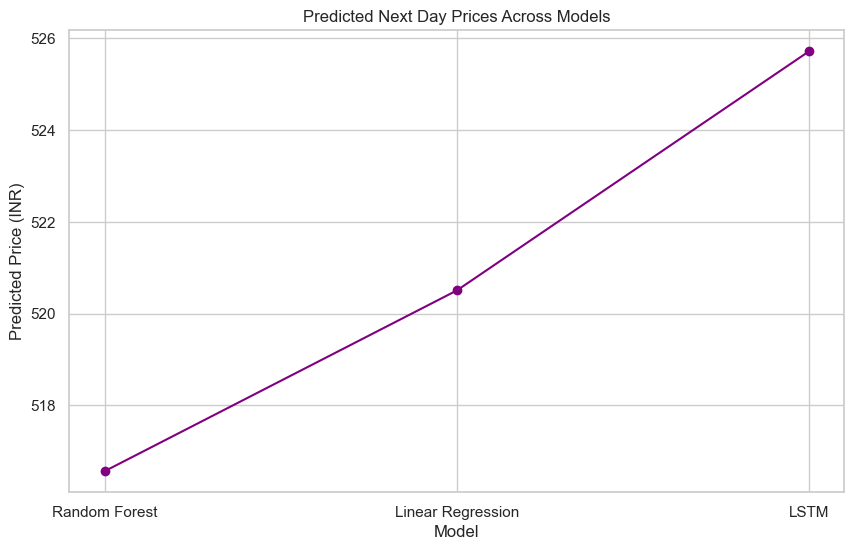

MAE values: [6.934012042051317, 4.778334305412201, 7.702590331364329]
RMSE values: [11.195617801432274, 7.602573342328745, 10.685037792935772]
R2 values: [0.7871747137164795, 0.9018594844137513, 0.8856767065675805]
Predicted next day prices: [516.5630067800003, 520.5045730243842, 525.72]


In [45]:
# Accuracy metrics for different models
models = ['Random Forest', 'Linear Regression', 'LSTM']
mae_values = [rf_mae, lr_mae, lstm_mae]
rmse_values = [rf_rmse, lr_rmse, lstm_rmse]
r2_values = [rf_r2, lr_r2, lstm_r2]

# Predicted next day prices
predicted_prices = [next_day_rf_prediction[0], next_day_lr_prediction[0], next_day_prediction[0][0]]

# Plotting MAE for different models
plt.figure(figsize=(10, 6))
plt.plot(models, mae_values, marker='o', linestyle='-', color='blue')
plt.title('MAE Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.show()

# Plotting RMSE for different models
plt.figure(figsize=(10, 6))
plt.plot(models, rmse_values, marker='o', linestyle='-', color='green')
plt.title('RMSE Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

# Plotting R2 for different models
plt.figure(figsize=(10, 6))
plt.plot(models, r2_values, marker='o', linestyle='-', color='orange')
plt.title('R2 Score Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

# Plotting predicted next day prices for different models
plt.figure(figsize=(10, 6))
plt.plot(models, predicted_prices, marker='o', linestyle='-', color='purple')
plt.title('Predicted Next Day Prices Across Models')
plt.xlabel('Model')
plt.ylabel('Predicted Price (INR)')
plt.grid(True)
plt.show()

# Print the values for comparison
print("MAE values:", mae_values)
print("RMSE values:", rmse_values)
print("R2 values:", r2_values)
print("Predicted next day prices:", predicted_prices)
